# 血糖値の数理シミュレーション

## 概要

・薬理学で、1コンパートメントモデルや2コンパートメントモデルといった薬物動態の数理モデルを習います。これは薬物の吸収、分布、代謝、排泄をモデル化したものでしたが、拡張すれば臓器の反応も考慮に入れることが可能です。今回は、拡張したモデルの例として、血糖値と、それに反応して分泌される血中インスリン濃度を予測する数理モデルを、pythonによるシミュレーションを使って紹介します。

・血糖値の数理モデルは、血糖値の動的挙動の理解や、糖尿病における血糖値の制御の必要性から、長年研究されてきました。[1]によれば、多くの血糖値の数理モデルは、Ackerman、Bolie、Wuの3人の数理モデルを出発点としています。今回は、数式が直観的に理解しやすく、シンプルなBolieのモデルでシミュレーションします。

## 数理モデル

・Bolieのモデルは、以下の通りです[2]（分かりやすいように表記を改変）。

・ここで、I(t)は時刻tの血中インスリン濃度　[unit/L]、pはインスリン投与量　[unit/L/hr]、G(t)は時刻tの血中グルコース濃度　[g/L]、qはグルコース投与量　[g/L/hr]です。α、β、γ、δは係数（すべて正）です。

$$
\frac{dI(t)}{dt} = p - \alpha I(t) + \beta G(t)
$$

$$
\frac{dG(t)}{dt} = q - \gamma I(t) - \delta G(t)
$$

## 式の解説

・1つ目の式の$\frac{dI(t)}{dt} = - \alpha I(t)$の部分は、インスリンに関する1コンパートメントモデルになっていることが分かります。これに、第1項としてインスリンの外部からの投与分pが、第3項としてグルコースの量に応じてインスリンが増加する項が加えられた形となっています。

・2つ目の式の$\frac{dG(t)}{dt} = - \delta G(t)$の部分は、グルコースに関する1コンパートメントモデルになっていることが分かります。これに、第1項としてグルコースの外部からの投与分qが、第2項としてインスリンの量に応じてグルコースが減少する項が加えられた形となっています。

## シミュレーションの条件

・それでは、pythonでこの数理モデルの挙動を見てみたいと思います。

・今回は、1日に3回食事をする健常者について、0時から24時までの血糖値と血中インスリン濃度をシミュレーションします。条件として以下を設定します。

①インスリンの外部投与はない。

②平均的な糖分摂取量300g/日を参考にし、グルコースは6から7時、12から13時、18から19時にそれぞれ1時間かけて100gが外部投与されるとする。

③簡単のため、摂食に関係なく生成・外部投与されるインスリン量、グルコース量は0とする。

## コード

・初期設定。

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

・シミュレーションのタイムステップを0.01時間、合計24時間に設定。

In [14]:
dt = 0.01
t = np.linspace(0, 24, 2401)

・係数α、β、γ、δは[2]の値を使います。生体によって決まる係数なので、本来は実験で決めます。インスリン投与量pは0、グルコース摂取量qは指定した時間で100/60[g/hr]、それ以外で0に設定します。

In [15]:
alpha = 0.916
beta =  0.198
gamma = 3.23
delta = 3.04

p = np.zeros((1, 2401))
q = np.zeros((1, 2401))

q[0, 601:700] = 100/60
q[0, 1201:1300] = 100/60
q[0, 1801:1900] = 100/60

・上の連続時間型の微分方程式ではシミュレーションできないので、離散型に変換しておきます。前進差分をとるとして$I(t) = \frac{I_{i + 1} - I_{i}}{\Delta t}$を代入し整理すると、以下のようになります。

$$
\begin{pmatrix}
I_{i + 1} \\
G_{i + 1}
\end{pmatrix}
=
\begin{pmatrix}
1 - \alpha \Delta t & \beta \Delta t \\
- \gamma \Delta t & 1 - \delta \Delta t
\end{pmatrix}
\begin{pmatrix}
I_i \\
G_i
\end{pmatrix}
+
\begin{pmatrix}
p \Delta t \\
q \Delta t
\end{pmatrix}
$$

これを用いて毎時間ステップの血中インスリン濃度 $I_i$ と血糖値 $G_i$ を計算します。最後に、100をかけて血糖値の単位をg/Lからmg/dLに変換しておきます。

In [16]:
A = np.array([[1-alpha*dt, beta*dt], [-gamma*dt, 1-delta*dt]])
P = np.concatenate((p, q), axis = 0) * dt

x = np.empty((2, 2401))
for i in range(2400):
    x[:, (i+1)] = np.dot(A, x[:, i]) + P[:, i]

x[1, :] = x[1, :] * 100

結果をプロットします。

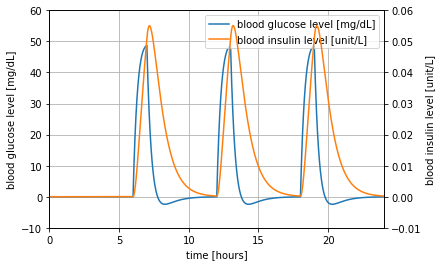

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1 = ax1.plot(t, x[1, :], 'C0', label = "blood glucose level [mg/dL]") 

ax2 = ax1.twinx()
ln2 = plt.plot(t, x[0, :], 'C1',label = "blood insulin level [unit/L]")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right', fontsize=10)

ax1.set_xlabel('time [hours]')
ax1.set_ylabel(r'blood glucose level [mg/dL]')
ax1.set_xlim([0,24])
ax1.set_ylim([-10,60])
ax1.grid(True)
ax2.set_ylabel(r'blood insulin level [unit/L]')
ax2.set_xlim([0,24])
ax2.set_ylim([-0.01,0.06])

plt.show()

## シミュレーションの結果

・上の図を見ると、6時、12時、18時に食事を開始してから、血糖値が50mg/dLほど上昇しています。また、遅れて血中インスリン濃度が上昇しています。

・その後は（インスリン量の増加の影響で）まず血糖値が低下し、その後血中インスリン濃度が低下しています。

## 実際はどうなのか？

・下の図が実際の血糖値と血中インスリン濃度の日内推移です[3]。これを見ると、上の数理モデルの結果と大体の傾向は合っています。ただ、実際のデータの方では血糖値とインスリンの立ち上がりに時間差がありません。これは、身体では、今回の数理モデルで考慮しなかったグルコースの消化管での吸収相があり、血糖値の立ち上がりが遅いためだと考えられます。

・実際のデータでは、大きな山が来た後必ず小さい山が来ていますが、これが何なのか、どうすれば数理モデルで再現できるのかはわかりませんでした。

In [18]:
from IPython.display import Image
Image(url= 'https://www.researchgate.net/profile/Michele_Solimena/publication/36789421/figure/fig3/AS:309923746467846@1450902987822/Glucose-and-insulin-over-the-day-Blood-insulin-closely-follows-glucose-A-meal-rich-in.png')

## 結論

血糖値の数理モデルをpythonで実装することで、血糖値と血中インスリン濃度の推移が確認できました。

## 参考

[1]  Keh-Dong Shianga and Fouad Kandeelc. "A computational model of the human glucose-insulin regulatory system". J Biomed Res. 2010 Sep; 24(5): 347–364. doi: 10.1016/S1674-8301(10)60048-6\
血糖値の数理モデルに関するレビューです。

[2] Bolie VW. "Coefficients of normal blood glucose regula-tion". J Appl Physiol 1961;16:783-8.\
Bolieの元論文です。

[3] Suckale Jakob and Solimena Michele. "Pancreas islets in metabolic signaling - focus on the β-cell". Frontiers in Bioscience. May 2008. DOI: 10.2741/3218.\
画像の引用元です。